# Shared structure in paired datasets: a notebook exploring the use of the ENSD, $\nu$ and distance measure $d_{\nu}$ in both synthetic and real neural data

In [1]:
import numpy as np
from scipy.stats import ortho_group 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import pandas as pd
import random as rd
import copy
import tqdm
import math

In [2]:
## Define functions to compute ENSD and PR
def PR(X):
    return (np.trace(X.T@X)**2)/np.trace(X.T@X@X.T@X)
def TR(X,Y):
    return np.trace( ((X.T@X)/np.trace(X.T@X)) @ ((Y.T@Y)/np.trace(Y.T@Y)) )
def ENSD(X, Y):
    #input is data matrix
    return PR(X)*PR(Y)*TR(X,Y)#
def computeDist(X, Y):
    return (2/math.pi)*(np.arccos(ENSD(X,Y)/np.sqrt(PR(X)*PR(Y))))
def eigvecOverlap(X,Y):
    ux, sx, vx = np.linalg.svd(X, full_matrices=True)                       
    uy, sy, vy = np.linalg.svd(Y, full_matrices=True) 
    return np.square(ux.T@uy)
def gen_orthonormal(dim):
    H = np.random.rand(dim, dim)
    u, s, vh = np.linalg.svd(H, full_matrices=False)
    return u#ortho_group.rvs(dim)

# 1) neural data: analysis of (uni-modal) connectivity data

Here, we will use the ENSD and distance measure to explore shared structure in the neural networks underlying parallel pathways in the fly olfactory system.  

In the fly, chemical signals in the environment (odorants) evoke activity in 51 genetically defined channels (glomeruli), with different odorants activating different subsets of these channels. While these channels vary in the breadth of their tuning to odorant features, a primary odorant-type tuning can and has been assigned for each channel. For example, a channel may be classified as primarily sensitive to pheremones or food sources e.g. decayed fruit.  Channel activations are relayed via  projection neurons (PNs) in the antennal lobe (AL) to two downstream areas: i) the mushroom body (MB), an area that has been shown to mediate adaptive olfactory learning and ii) the lateral horn (LH), a relatively poorly characterized area that is thought to mediate innate olfactory behaviour. Over the past decade, these circuits have been the focus of intense research attempting to understand how information is represented across these channels, both in an attempt to understand which odorant features are relevant to olfactory processing as well as, more generally, how biological systems represent complex, high-dimensional environments without any clear statistical structure.

We will use connectivity data from the hemibrain connectome - Scheffer, 2020, eLife, https://doi.org/10.7554/eLife.57443.  Specifically, two connectivity matrices, each describing the number of synapses between PNs and downstream cells in MB and LH.  We will work with a simpler version of this data - each PN is associated to a single channel (glomerulus) - we sum all PNs corresponding to the same glomerulus and work with data of dimensions glomerulus * downstream (LH or MB) cells.

Let's first define some helper functions to i) preprocess the data (threshold and center) and ii) generate samples from a null model of the connectivity data, i.e. by shuffling the data appropriately and iii) to compare our statistics of interest in the case of data vs a null model.

In [ ]:
# i) preprocess data
def Threshhold(X, t):
    # thresholds matrix X at value t - returns binary matrix
    return (X >= t)*1

def centerData(Q, dimn):
# mean centers data along specified dimension
    if dimn == "row":
        Qn = Q-np.tile(Q.mean(1), [np.shape(Q)[1], 1]).T
    elif dimn == "col":
        Qn = Q-np.tile(Q.mean(0), [np.shape(Q)[0], 1])
    else:
        print("enter valid dimension (row, col)")
    return Qn

# ii) generate a sample from the null model
def ShuffleMatrix(X):
    # generates a sample from the null model
    # takes binary matrix X (data) and shuffles it, such that sums in dimension 0 and 1 are preserved
    sdim1 = np.shape(X)[0]
    X_sum0 = np.sum(X, 0)
    X_sum1 = np.sum(X, 1).T
    X_null = np.zeros(np.shape(X))
    c=-1
    for i in X_sum0:
        c+=1
        WEIGHTS = copy.deepcopy(X_sum1)
        for k in range(i):
            n_ind = rd.choices(range(0,sdim1), weights = WEIGHTS, k = 1)
            X_sum1[n_ind] -= 1
            WEIGHTS[n_ind] = 0
            X_null[n_ind, c] = 1
    if np.sum(np.sum(X_null,0) - np.sum(X,0)) != 0:
        X_null = ShuffleMatrix(X)
    return X_null


# iii) compute statistics of interest and display simmary graphics
def computeStats(X, Y):
# compiutes ENSD and distance between X (binary matrix) and Y [data].  Also computes statistics for shuffled X and Y [shuffled].
# returns the delta defined by (shuffled - data)/ data (% change upon shuffling)
    Xc = centerData(X, "row")
    Yc = centerData(Y, "row")

    nX = ShuffleMatrix(X)
    nXc = centerData(nX, "row")
    
    nu_XY = ENSD(Xc.T, Yc.T)
    nu_nXY = ENSD(nXc.T, Yc.T)
    
    dist_XY = computeDist(Xc.T, Yc.T)
    dist_nXY = computeDist(nXc.T, Yc.T)
    
    del_ENSD = (nu_nXY - nu_XY)/ nu_XY
    del_dist = (dist_nXY - dist_XY)/ dist_XY

    return (del_ENSD, del_dist)                


def compare_ENSD_Dist_XY(X, Y, nreps=20, suptit=""):
# compute ENSD and distance between datasets X and Y.  Compare this to shuffled_X and Y
    delNU = []
    delDist = []

    for i in range(nreps):
        ans = computeStats(X, Y)
        delNU.append(ans[0])
        delDist.append(ans[1])
        
    # plot
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.violinplot(delNU, showmeans=True, showextrema=True, showmedians=True)
    ax1.set_title("Delta ENSD")

    ax2.violinplot(delDist, showmeans=True, showextrema=True, showmedians=True) 
    ax2.set_title("Delta distance")
    
    fig.tight_layout(pad=1.0)
    fig.suptitle(suptit)
    plt.show()

    return delNU, delDist


def compareW_Wn(X, Y, suptit):
# Look at eigenvector overlaps via matrix W. Compare W matrices from X and Y with shuffled_X and Y
    Xc = centerData(X, "row")
    Yc = centerData(Y, "row")

    nX = ShuffleMatrix(X)
    nXc = centerData(nX, "row")
        
    W = eigvecOverlap(Xc, Yc)                        
    Wn = eigvecOverlap(nXc, Yc)
    
    # the svd algorithm orders eigenvectors by their corresponding singular value.
    # We'll look at the top 5 (highest variance) basis vectors:
    W = W[:5,:5]
    Wn = Wn[:5,:5]
    
    # plot
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    
    f1 = ax1.imshow(W)
    plt.colorbar(f1,ax=ax1,shrink=0.25)
    ax1.set_title("W")
    ax1.set_xlabel("dataset Y eigenvecs")
    ax1.set_ylabel("dataset X eigenvecs")

    f2 = ax2.imshow(Wn)
    plt.colorbar(f2,ax=ax2,shrink=0.25)
    ax2.set_title("Wn")
    ax2.set_xlabel("dataset Y eigenvecs")
    ax2.set_ylabel("shuffled X eigenvecs")
    
    f3 = ax3.imshow(W - Wn)
    plt.colorbar(f3,ax=ax3,shrink=0.25)
    ax3.set_title("W - Wn")
    ax3.set_xlabel("Y eigenvecs")
    ax3.set_ylabel("X eigenvecs")

    fig.tight_layout(pad=1.0)
    fig.suptitle(suptit)
    plt.show()
    

Let's have a look at the connectivity data

In [ ]:
# load datasets
MBdata = pd.read_pickle('MB_conn.pkl').to_numpy()
LHdata = pd.read_pickle('LH_conn.pkl').to_numpy()

# As we're examining binary connectivity in this notebook, let's look at binarized data. We set the threshold to be 3, meaning any connections with over 3 synapses are considered a valid connection.
thresh = 3
X = Threshhold(MBdata, thresh)
Y = Threshhold(LHdata, thresh)

plt.imshow(Y)
plt.xlabel("cells in LH")
plt.ylabel("glomeruli")
plt.title("binary LH connectivity: L")
axes=plt.gca()
axes.set_aspect(10)
plt.show()

plt.imshow(X)
plt.xlabel("cells in MB")
plt.ylabel("glomeruli")
plt.title("binary MB connectivity: M")
axes=plt.gca()
axes.set_aspect(10)
plt.show()

Below, we compare a) the size of the shared subspace (ENSD, $\nu$) and b) the distance ($d_{\nu}$) between the Lateral Horn (LH) and Mushroom Body (MB) connectivity data.  To understand if the computed statistics ($\nu, d_{\nu}) are significant, we compare them to those obtained when the MB dataset is shuffled.  The shuffling procedure should break any structure in the matrix, but not change the statitsics of the data too much - the procedure we employ maintains the marginal statistics (the row and column sums) - see the ShuffleMatrix function.  The MB dataset is chosen to be shuffled because it is  significantly less structured/more random than the LH dataset (you can compute the PR for each matrix and compare ito the respective null to see this).

We report changes in ENSD or distance upon shuffling as the percentage change (or $\Delta$).  A positive $<\Delta\nu>$ indicates that the actual paired datasets (X and Y) share a subspace of lower dimensionality than would be expected when structure in one dataset (X) is scrambled (null model).  Conversely, a negative $<\Delta\nu>$ indicates that the paired datasets (X and Y) share a subspace of higher dimensionality than would be expected under the null model.  A positive $<\Delta d_{\nu}>$ indicates that the data matrices are closer together (according to our distance metric) than expected under the null model. 

In [ ]:
# MB and LH
threshold = 3
nreps = 20
suptit = "MB - LH"

# threshold data
X = Threshhold(MBdata, threshold)
Y = Threshhold(LHdata, threshold)

# Look at change in ENSD and distance when connectivity is shuffled
delNU, delDist = compare_ENSD_Dist_XY(X, Y, nreps, suptit)
      
# Look at eigenvector overlaps via matrix W vs a shuffled sxample 
# we'll only look at the top 5 eigenvectors (ordered by singular value), i.e. those that explain most variance in the data
compareW_Wn(X, Y, "MB - LH")


If we see a strong alignment, for example when the threshold is set at 3, eigenvectors 1 of M and 2 of L have a high overlap score, suggesting a ~1D shared subspace.  We can probe that shared subspace to look for interpretable structure (see our preprint (Figure 4) for an example where each glomerulus is colour coded by its primary odor type sensitivity).

-------------------------------------

# 4) multi-modal neural data: shared structure between neural activity and connectivity in the fruit fly olfactory system

We can use the ENSD to probe shared structure in datasets of different modalities.  As an example, we look at shared variability between a) connectivity datasets from the previous example and b) response data from the same channels (glomeruli) in response to a panel of different odorants.  The data from b) are taken from Badel et al, Neuron 2016, http://dx.doi.org/10.1016/j.neuron.2016.05.022

i) Lets first load and look at the data - the first dimension (glomeruli) of all three matrices are aligned.  Note that we will process this data (binarizing the connectivity and centering all matrices) before computing our statistics of interest.

In [ ]:
LH_subset_data = pd.read_pickle('LH_subset_conn.pkl').to_numpy()
MB_subset_data = pd.read_pickle('MB_subset_conn.pkl').to_numpy()

K_activities_data = pd.read_pickle('K_znorm_subset.pkl').to_numpy()      # z scored data
# K_activities_data = pd.read_pickle('K_subset.pkl').to_numpy()          # raw data

plt.imshow(K_activities_data)
plt.xlabel("odors")
plt.ylabel("glomeruli")
plt.title("response data: K")
axes.set_aspect(10)
plt.show()

plt.imshow(LH_subset_data)
plt.xlabel("cells in LH")
plt.ylabel("glomeruli")
plt.title("LH connectivity: L")
axes=plt.gca()
axes.set_aspect(10)
plt.show()

plt.imshow(MB_subset_data)
plt.xlabel("cells in MB")
plt.ylabel("glomeruli")
plt.title("MB connectivity: M")
axes=plt.gca()
axes.set_aspect(10)
plt.show()


ii) As in example 4, we use shuffled connectivity matrices to look for alignment between two datasets that is significant (wouldn't be expected for random matrices with the same marginal statistics).  We compare the ENSD/distance between the response and connectivity data, with that of response and shuffled data.

Again, a positive $<\Delta\nu>$ indicates that the actual data (X and Y) share a subspace of lower dimensionality than would be expected under the null model.  A positive $<\Delta d_{\nu}>$ indicates that the data matrices are closer together (according to our distance metric) than expected under the null model. 

In [ ]:
# i) MB and K 
threshold = 3
nreps = 20
suptit = 'MB - K'

# i) load and threshold connectivity
X = MB_subset_data
X = Threshhold(X, threshold)
Y = K_activities_data

# Look at change in ENSD and distance when connectivity is shuffled
delNU, delDist = compare_ENSD_Dist_XY(X, Y, nreps, suptit)
      
# Look at eigenvector overlaps via matrix W vs a shuffled sxample
compareW_Wn(X, Y, suptit)


In [ ]:
# i) LH and K 
suptit = 'LH - K'
threshold = 3
nreps = 20

X = LH_subset_data
X = Threshhold(X, threshold)
Y = K_activities_data
    
# Look at change in ENSD and distance when connectivity is shuffled
delNU, delDist = compare_ENSD_Dist_XY(X, Y, nreps, suptit)    
    
    
# Look at eigenvector overlaps via matrix W vs a shuffled sxample   
compareW_Wn(X, Y, suptit)


These results suggest that LH shares more structure with K than does the MB (a larger positive change in $\nu$ upon shuffling).  Note also how the ENSD is more discriminative of this shared structure than the distance measure (which doesn't change significantly when either LH or MB is shuffled).

# 3) Toy data: amplification of shared dimensionality
Here we explore a perhaps counterintuitive property of the ENSD: the ENSD can be higher than the minimum PR of two datasets.
We generate toy datasets X and Y with the same orthonormal basis set but with eigenspectra decay at different rates (determined by kx and ky). Geometrically, this means that variance is distributed differently across the shared basis.

In [ ]:
#set dimensionalities of matrix
n = 10 
p = 10

kx = .5 #decay rate for eigenspectrum of x
ky = .15 #decay rate for eigenspectrum of y
inds = np.linspace(1, p, p)
sig_x = np.exp(-inds*kx) #eigenspectrum of x
sig_y = np.exp(-inds*ky) # eigenspectrum of y
x_axis = np.linspace(1,10,10) #for plotting

#plot eigenspectrum decay
plt.plot(x_axis, sig_x, 'o--',label = 'x')
plt.plot(x_axis, sig_y, 'o--', label = 'y')
plt.legend()
plt.show()

#generate matrices
U = gen_orthonormal(n)
V = gen_orthonormal(p)
Sx = sig_x*np.eye(n)
Sy = sig_y*np.eye(n)
X = U@Sx@V.T
Y = U@Sy@V.T

print('PR X', PR(X))
print('PR Y', PR(Y))
print('ENSD', ENSD(X, Y))

We see here what the effect of the eigenspectrum decay is on the PR of X and Y - X has a faster decay, and therefore a smaller PR, even though the matrices are identical otherwise. We also see a somewhat counterintuitive property of the ENSD: that the ENSD can be higher than the PR of the matrices.  


To give more intuition into this amplification of shared dimensionality, we generated two toy datasets each confined to a sphere or an ellipsoid. Both are three dimensional shapes that share one axis, with the ellipsoid having a distortion along the x and y axes.

In [3]:
# You may want to clear and restart the kernel here (remember to rerun the first two cells)*
from matplotlib.pyplot import *

nsamp = 2000 #number of data points
rad = 1 #radius of circle
noise = 0.1 #noisiness of data
#generate angles uniformly
theta = np.random.uniform(0, np.pi,nsamp) 
psi = np.random.uniform(0, 2*np.pi,nsamp)

In [4]:
# generate spherically distributed data
x = rad*np.sin(psi)*np.cos(theta) + noise*rad*np.random.normal(size = nsamp)
y = rad*np.sin(psi)*np.sin(theta) + noise*rad*np.random.normal(size = nsamp)
z = rad*np.cos(psi) + noise*rad*np.random.normal(size = nsamp)

<IPython.core.display.Javascript object>


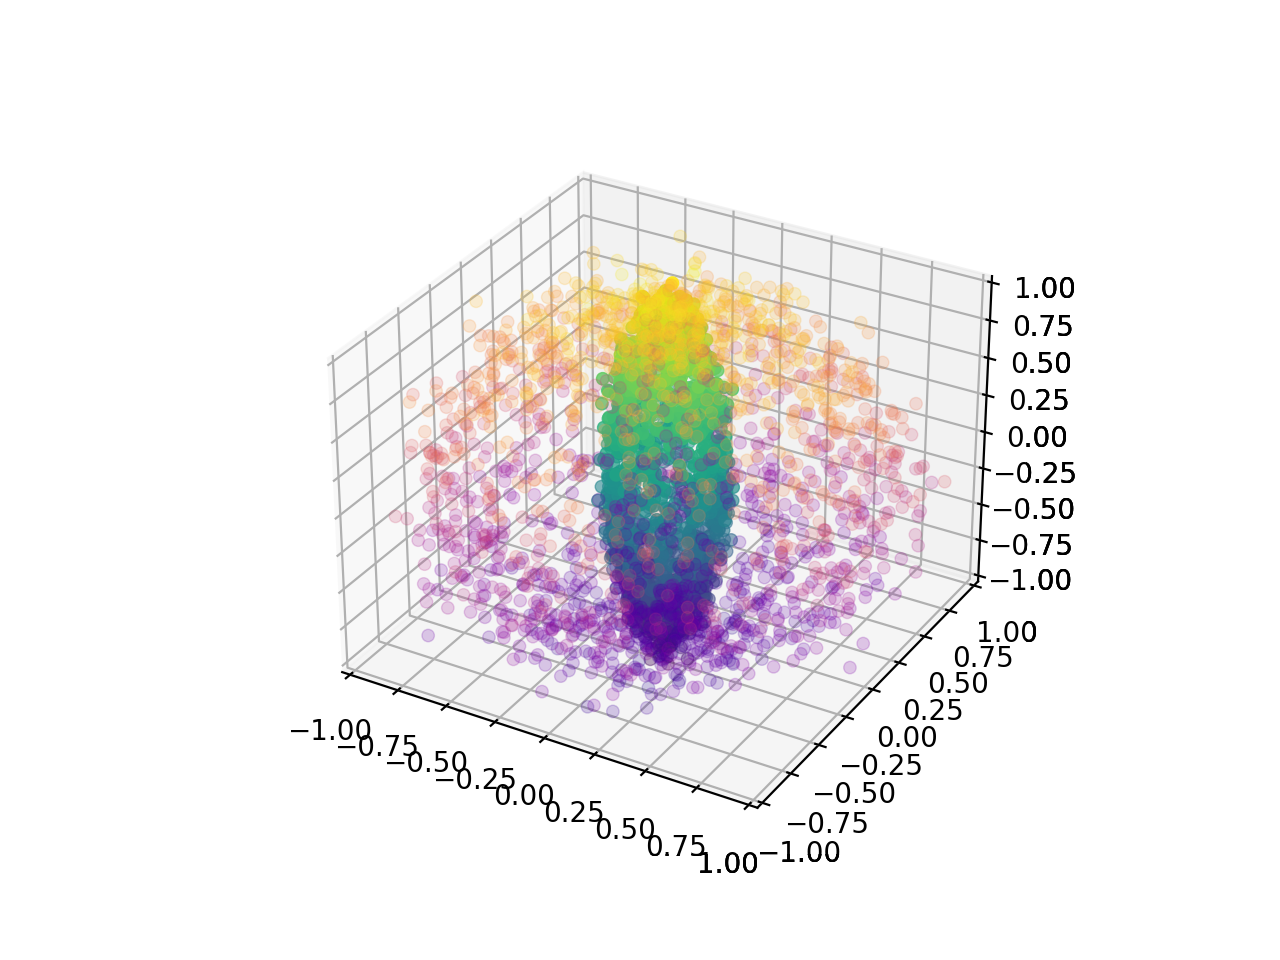

(-1.0, 1.0)

In [5]:
%matplotlib notebook
ax = axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

In [6]:
#generate elipsoidally distributed data
new_x = 0.25*rad*np.sin(psi)*np.cos(theta) + 0.25*noise*rad*np.random.normal(size = nsamp)
new_y = 0.25*rad*np.sin(psi)*np.sin(theta) + 0.25*noise*rad*np.random.normal(size = nsamp)

%matplotlib notebook
ax = axes(projection='3d')
ax.scatter(new_x, new_y, z, c=z, cmap='viridis', linewidth=0.5);
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

(-1.0, 1.0)

In [7]:
sphere = np.vstack((x,y,z))
tube = np.vstack((new_x,new_y,z))

In [8]:
%matplotlib notebook
ax = axes(projection='3d')
ax.scatter(x, y, z, c=z, cmap = 'plasma', linewidth=0.5, alpha = 0.2);
ax.scatter(new_x, new_y, z, c=z, cmap='viridis', linewidth=0.5);
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)


(-1.0, 1.0)

In [9]:
print('sphere (PR)' , PR(sphere))
print('tube (PR)', PR(tube))
print('shared dim (ENSD)', ENSD(sphere, tube))

sphere (PR) 2.685605817779715
tube (PR) 1.1298216045067586
shared dim (ENSD) 1.4528574507188297


We see that the ENSD returns dimensionality scores intermediate between the dimensionalities (measured by the PR) of the individual datasets. This happens because the ENSD captures the "effective" number of shared dimensions. Although the ellipsoid data has a PR of almost 1, as it is mostly distributed along the z axis, it has a component of variability that is shared with the spherical data along the x and y axes. This means that the shared dimensionality between the two datasets should actually be larger than the PR of just the ellipsoid.